In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from coulombexp_sim_2024_Zhihao import (
    read_instructions,
    explode_fragments,
    get_list_of_arrays
)
from numpy.random import default_rng

In [3]:
##############################################################################
# User Settings
##############################################################################
os.chdir(r'C:\Users\zhiha\Desktop\computation\OCS\CEI_simulation')

input_file = 'OCS.txt'   # The instructions file
shots = 5000            # Number of laser shots to simulate

# Read and build the Experiment
experiment = read_instructions(input_file)

# Additional parameters
experiment.sigma = 0.2     # Variation in Poisson event rate
experiment.epsilon = 0.8   # Detection efficiency

# If using an augmented Poisson distribution (Poisson with a random mean),
# we define the truncated normal distribution that modifies the mean (v0):
mu = 1.0
lower, upper = 0.0, 1000.0
experiment.normaldist(experiment.sigma, upper, lower, mu)

##############################################################################

In [4]:
##############################################################################
# Simulation Function
##############################################################################
def cycle_over_shots(shots_array, expmnt=experiment):
    """
    Runs the simulation over a set of shots. For each shot:
      1) Draw a random scaling factor gamma from truncated normal (if sigma != 0).
      2) Multiply v0 by gamma => effective event rate for that shot.
      3) Draw from a Poisson distribution => number of molecules created.
      4) Distribute these molecules across fragmentation channels (multinomial).
      5) Vibrate, fragment, and explode them, collecting final (x,y,z,t,m,q,vx,vy,vz).
      6) Store in DataFrame.

    Returns
    -------
    data : pd.DataFrame
        Columns = [x, y, z, t, m, q, vx, vy, vz, shot]
    """
    rng = default_rng()

    # Lists to accumulate results
    xs, ys, zs = [], [], []
    ts, ms, qs = [], [], []
    vxs, vys, vzs = [], [], []
    shot_ids = []

    # Loop over each shot
    for shot_no in shots_array:
        # 1) If sigma=0, there's no truncated normal
        if expmnt.sigma <= 0:
            gamma = 1.0
        else:
            gamma = float(expmnt.Gamma_dist.rvs())

        # 2) Effective event rate
        effective_rate = gamma * expmnt.v0

        # 3) Number of molecules from Poisson
        n_molecules = rng.poisson(effective_rate)
        
        # 4) Distribute among channels by multinomial
        channel_counts = rng.multinomial(n_molecules, expmnt.channel_probs)

        # Build molecules
        all_molecules = []
        for i_ch, count in enumerate(channel_counts):
            # Create 'count' molecules for channel i_ch
            channel_mols = []
            for _ in range(count):
                mol_copy = expmnt.create_molecule_obj()
                # Vibrate
                mol_copy.vib()
                # Fragment
                mol_copy.create_fragments(i_ch, expmnt)
                channel_mols.append(mol_copy)
            all_molecules.extend(channel_mols)

        # 5) Explode them
        x, y, z, t, m, q, vx, vy, vz = explode_fragments(all_molecules, epsilon=expmnt.epsilon)

        xs.extend(x)
        ys.extend(y)
        zs.extend(z)
        ts.extend(t)
        ms.extend(m)
        qs.extend(q)
        vxs.extend(vx)
        vys.extend(vy)
        vzs.extend(vz)

        # Book-keeping: which shot
        shot_ids.extend([shot_no] * len(x))

    # 6) Build and return DataFrame
    data = pd.DataFrame({
        'x': xs,
        'y': ys,
        'z': zs,
        't': ts,
        'm': ms,
        'q': qs,
        'vx': vxs,
        'vy': vys,
        'vz': vzs,
        'shot': shot_ids
    })
    return data

In [5]:
##############################################################################
# Run the simulation
##############################################################################
laser_shots = np.arange(1, shots + 1)
df = cycle_over_shots(laser_shots)

outname = f"{experiment.name}_{shots}_shots_sigma{experiment.sigma}_v0{experiment.v0}_eps{experiment.epsilon}.csv"
df.to_csv(outname, index=False)
print(f"Saved Data to {outname}")

Saved Data to OCS_5000_shots_sigma0.2_v030.0_eps0.8.csv


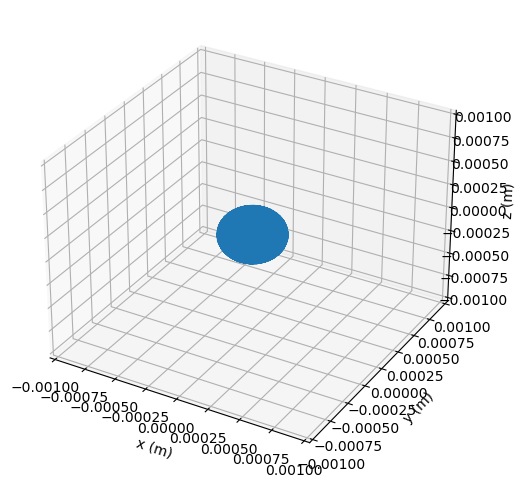

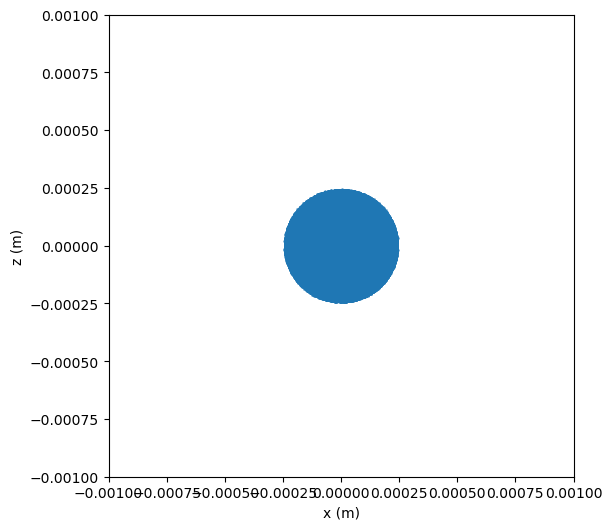

In [9]:
##############################################################################
# Quick Plot of Results (3D)
##############################################################################
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=1,alpha=0.6)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.set_xlim3d(-1e-3, 1e-3)
ax.set_ylim3d(-1e-3, 1e-3)
ax.set_zlim3d(-1e-3, 1e-3)
plt.show()

##############################################################################
# 2D Projection
##############################################################################
plt.figure(figsize=(6,6))
plt.scatter(df['x'], df['z'], s=1, alpha=0.6)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.show()

In [15]:
##############################################################################
# Pixelation Step (Optional)
##############################################################################
def pixelate(df_in, xbins, ybins, tbins):
    """
    Converts (p_x,p_y,t) into discrete bin indices. For example,
    for imaging or histogramming.

    Here, let's do an example with mass/charge as 'time' dimension.
    """
    # Define mass/charge 这里结果保留一位小数
    df_in['mq'] = np.round(df_in['m'] / df_in['q'], 2).fillna(0).astype(int)
    xpix = np.digitize(df_in['p_x'], xbins)
    ypix = np.digitize(df_in['p_y'], ybins)
    # Use integer m/q as 'time' bin
    t_binned = df_in['mq'].values

    # shot is also stored
    shot_ids = df_in['shot'].values

    # Build a new DataFrame
    df_pix = pd.DataFrame({
        'x_bin': xpix,
        'y_bin': ypix,
        't_bin': t_binned,
        'shot': shot_ids
    })
    return df_pix




In [ ]:
print(df.head())

          x         y         z         t       m  q            vx  \
0 -0.000046 -0.000018 -0.000080  0.000002  12.011  1  -4578.226676   
1 -0.000042  0.000025  0.000129  0.000002  32.060  3  -4170.788232   
2  0.000073  0.000016  0.000002  0.000002  12.011  1   7275.895210   
3  0.000138  0.000192 -0.000023  0.000001  15.999  2  13848.186121   
4 -0.000096 -0.000102  0.000011  0.000002  32.060  3  -9636.553559   

             vy            vz  shot  
0  -1802.294762  -8022.084735     1  
1   2467.563574  12923.515286     1  
2   1573.083996    196.908198     1  
3  19230.352932  -2261.446793     1  
4 -10185.924156   1054.766777     1  


In [16]:
# Calculate the momentum on x y and z axis and transfer the momentum to the coordinate system
# momentum unit is atomic unit


#atomic unit of momentum is 1 a.u. = 1.99285e-24 kg m/s
mom_constant = 1.99285e-24

df['p_x'] = df['m'] * df['vx']/(1000 * mom_constant)
df['p_y'] = df['m'] * df['vy']/(1000 * mom_constant)
df['p_z'] = df['m'] * df['vz']/(1000 * mom_constant)

df['radial_extent'] = np.sqrt(df.p_x**2 + df.p_y**2 + df.p_z**2)
#df['radial_extent'] = np.sqrt(df.x**2 + df.y**2 + df.z**2)

maxrad = df['radial_extent'].max()
pixs = 324
xbins = np.linspace(-1.05 * maxrad, 1.05 * maxrad, pixs)
ybins = xbins
tbins = np.arange(1001)  # if we treat m/q up to ~1000, e.g.

pixel_df = pixelate(df, xbins, ybins, tbins)
#pixel_df.to_csv(outname.replace('.csv', '_pixelated.csv'), index=False)
print(pixel_df.head())

   x_bin  y_bin  t_bin  shot
0    144    155     12     1
1    118    188     10     1
2    191    168     12     1
3    234    263      8     1
4     61     55     10     1
